# Сравнительный анализ методов имитации отжига и генетических алгоритмов

## Цель работы
Определение предпочтительных методов решения каждой из представленных задач и выделение особенностей работы методов при их решении.
## Набор задач для наиболее показательного сравнения методов.
1. Задача о расстановке ферзей
2. Задача Коммивояжера

## Задача о расстановке ферзей
### Формулировка
Дано шахматное поле размера N × N.
Требуется разместить на нём N ферзей так, чтобы ни одна пара ферзей не угрожала друг другу.
### Решения
1. Полный перебор
2. Перебор перестановок 
3. Динамическое программирование (для очень маленьких досок)
4. Эволюционные алгоритмы
5. Градиентный спуск (отжиг)
### Почему используем отжиг и генетические алгоритмы?
Очевидно, что первые 2 способа решения будут работать за O(N!), что позволит за приемлемое время находить ответ только для очень маленьких досок. Динамическое программирование тут тоже особо не помогает, ибо у нас все равно порядка O(N!) состояний, которые требуется посетить. В то же время эвристические алгоритмы вроде отжига и генетического алгоритма позволяют решить эту задачу для более больших досок. При этом использовать неточные методы нас подталкивает еще и наличие критерия, по которому мы можем определить, устраивает нас ответ или нет (если ферзи друг друга не бьют, то все хорошо, ответ один из лучших).
### Целевая функция
Для обоих алгоритмов она будет одинакова. Но тут встает вопрос: какую же функцию использовать? При использовании бинарной функциии вида: хорошая доска (никто друг друга не бьет), плохая доска, возникает проблема - неинформативность. Алгоритмы банально не смогут сказать, а какое из плохих решений ближе к правильному. Я предлагаю использовать для текущей задачи следующую функцию стоимости: количество пар ферзей, которые друг друга бьют. Данную функцию нужно минимизировать.
### Область решений
Мы могли бы считать областью решений все возможные расстановки ферзей без учета условия о том, что они не должны друг друга бить. Но эта область довольно крупная. Давайте ее сузим. Мы знаем, что задачу можно решить перебором перестановок, и, действительно, ни в одной строке и ни в одном столбце не может стоять более 1 ферзя. Наша область решений - все возможные перестановки чисел от 1 до N.

## Решение задачи о расстановке ферзей методом отжига

### Функция генерации случайного решения
Будет общей для ГА и МО. Представляет собой генерацию случайной перестановки.

In [2]:
import random


def make_permutation(n: int, rng: random.Random) -> list[int]:
    perm = list(range(n))
    rng.shuffle(perm)
    return perm

### Функции температур
Пердоставлю сразу несколько функций температур для метода отжига, чтобы в дальнейшем сконструировать несколько вариаций алгоритма.

In [3]:
funcs = []

def temp_func_1(iteration: int) -> float:
    return 1.0 / iteration

def temp_func_2(iteration: int) -> float:
    return 0.99 ** (iteration - 1)

funcs = [temp_func_1, temp_func_2]

### Функция мутации
Тут можно использовать очень простую функцию мутации - смена двух случайных индексов.

In [4]:
def mutate_func(permutation: list[int], rng: random.Random) -> list[int]:
    permutation = permutation.copy()
    i, j = rng.sample(range(len(permutation)), 2)
    permutation[i], permutation[j] = permutation[j], permutation[i]
    return permutation

### Целевая функция

In [5]:
def cost_func(permutation: list[int]) -> float:
    diag1 = [0 for i in range(len(permutation) * 2 - 1)]
    diag2 = [0 for i in range(len(permutation) * 2 - 1)]
    for i in range(len(permutation)):
        diag1[permutation[i] + i] += 1
        diag2[permutation[i] - i + len(permutation) - 1] += 1
    return sum(d * (d-1) / 2 for d in diag1) + sum(d * (d-1) / 2 for d in diag2)

### Класс алгоритма метода отжига
Находится в algorithms/sa.py  
Определим несколько объектов с разными функциями температур

In [6]:
import os
import sys


sys.path.append(os.path.abspath("../src"))

from sa_ga_comparison.algorithms.sa import SimulatedAnnealing


random_seed = 13

### Пробуем получить решения
Сгенерируем решения для N = [10, 50, 100]

In [7]:
iterations = 100000

for N in [10, 50, 100]:
    sa = [SimulatedAnnealing(lambda rng: make_permutation(N, rng), funcs[i], mutate_func, cost_func, random.Random(random_seed)) for i in range(2)]
    for s in sa:
        res = s.get_solution(iterations)
        print(res[0], res[1])
       

[7, 4, 2, 0, 9, 1, 5, 8, 6, 3] 0.0
[4, 2, 7, 3, 6, 0, 9, 1, 5, 8] 0.0
[31, 25, 7, 29, 45, 40, 19, 0, 2, 20, 12, 36, 44, 35, 3, 43, 14, 16, 28, 23, 17, 30, 38, 18, 15, 9, 1, 8, 42, 46, 22, 32, 47, 33, 37, 41, 4, 27, 5, 11, 48, 21, 49, 39, 13, 24, 34, 6, 26, 10] 0.0
[13, 11, 20, 35, 41, 29, 1, 32, 28, 26, 38, 45, 16, 4, 49, 44, 46, 9, 14, 2, 17, 3, 31, 37, 43, 6, 25, 0, 18, 15, 24, 10, 33, 36, 39, 42, 21, 5, 12, 8, 40, 47, 30, 27, 22, 7, 48, 34, 23, 19] 0.0
[61, 9, 62, 22, 3, 90, 28, 32, 41, 45, 33, 76, 36, 54, 58, 20, 82, 64, 15, 17, 63, 34, 74, 99, 8, 51, 44, 59, 31, 87, 93, 14, 69, 95, 91, 80, 4, 83, 42, 49, 26, 10, 27, 13, 73, 79, 97, 24, 98, 1, 39, 43, 6, 12, 19, 75, 71, 57, 96, 86, 0, 72, 37, 50, 85, 67, 2, 30, 84, 81, 23, 77, 38, 35, 5, 56, 66, 78, 60, 21, 25, 55, 89, 29, 7, 18, 53, 48, 46, 40, 47, 16, 52, 11, 65, 88, 68, 70, 92, 94] 0.0
[67, 79, 50, 13, 68, 26, 37, 20, 54, 75, 19, 88, 65, 52, 25, 17, 44, 73, 43, 55, 72, 97, 34, 60, 6, 23, 81, 95, 91, 7, 71, 22, 74, 16, 93, 10, 90

### Оценка результатов и оптимизация
Как видно из вышенаходящихся результатов, метод отжига позволяет решить задачу для N до 100 за приемлемое время, то есть преимущество над переборными алгоритмами очевидно. Но есть заметная проблема, так как класс отжига, написанный мной, представляет собой универсальный класс под решение любых задач, то многие моменты в нем не соптимизированы и работают дольше, чем могли бы (например, вычисление целевой функции). Давайте я перепишу функцию get_solution с учетом этого и попробую решить задачу для N = 200, 300, 500.

In [8]:
from math import exp


def get_solution(generation_fn, 
                 mutation_fn, 
                 cost_fn, 
                 rng,
                 max_iters):
        history = []

        current_solution = generation_fn(rng)
        current_cost = cost_fn(current_solution)
        history.append((current_solution, current_cost))

        best_solution = current_solution
        best_cost = current_cost

        temp = 1

        for iteration in range(1, max_iters + 1):

            if temp <= 0:
                raise ValueError("Temperature function must not return non-positive values")

            candidate_solution = mutation_fn(current_solution, rng)
            candidate_cost = cost_fn(candidate_solution)

            if candidate_cost < current_cost:
                current_solution = candidate_solution
                current_cost = candidate_cost
                best_solution = current_solution
                best_cost = current_cost
            elif rng.random() < exp((current_cost - candidate_cost) / temp):
                current_solution = candidate_solution
                current_cost = candidate_cost

            history.append((current_solution.copy(), current_cost))
            temp *= 0.99
            

        return (best_solution, best_cost, history)


for N in [200, 500, 1000]:
    res = get_solution(lambda rng: make_permutation(N, rng), mutate_func, cost_func, random.Random(random_seed), iterations)
    print(res[0], res[1])

[146, 198, 12, 40, 140, 165, 123, 157, 122, 156, 94, 163, 45, 29, 84, 147, 18, 143, 141, 34, 86, 33, 58, 126, 47, 50, 75, 164, 166, 178, 193, 5, 137, 59, 77, 81, 36, 181, 46, 38, 161, 72, 113, 199, 91, 13, 15, 182, 83, 151, 17, 155, 176, 23, 154, 85, 53, 64, 185, 55, 170, 54, 0, 124, 131, 93, 95, 145, 25, 4, 114, 177, 78, 6, 162, 11, 90, 139, 69, 57, 179, 67, 150, 42, 191, 160, 70, 167, 109, 79, 135, 180, 173, 112, 60, 68, 148, 188, 20, 43, 134, 89, 129, 195, 105, 153, 21, 16, 168, 8, 14, 27, 39, 186, 138, 192, 103, 63, 190, 130, 152, 171, 19, 62, 127, 28, 120, 196, 49, 121, 22, 3, 183, 10, 52, 82, 101, 119, 194, 197, 144, 51, 125, 92, 184, 108, 159, 41, 74, 44, 7, 32, 30, 104, 107, 111, 174, 133, 31, 88, 73, 37, 117, 106, 169, 187, 1, 142, 132, 71, 110, 116, 9, 115, 128, 35, 2, 97, 61, 48, 189, 87, 56, 100, 98, 26, 175, 76, 136, 149, 80, 24, 99, 118, 102, 172, 66, 158, 96, 65] 0.0
[146, 255, 125, 309, 345, 177, 139, 483, 120, 454, 470, 232, 218, 236, 305, 140, 251, 380, 274, 307, 148,

### Оценка результатов соптимизированного алгоритма
Как видно, метод отжига позволяет решать задачу для N <= 500. Для N = 1000 уже не получается найти расстановку без бьющих друг друга пар, но их количество очень мало, так что, увеличив количество итераций хотя бы до 1000000, можно ожидать, что задача будет решена и для N = 1000. Остановимся на количестве итераций = 100000, так как наша задача сравнить эффективность с ГА.

### Визуализация изменения текущей стоимости
Для лучшего понимания работы метода отжига провизуализируем изменение значения целевой функции для N = 10 с количеством итераций = 1000.

0.0


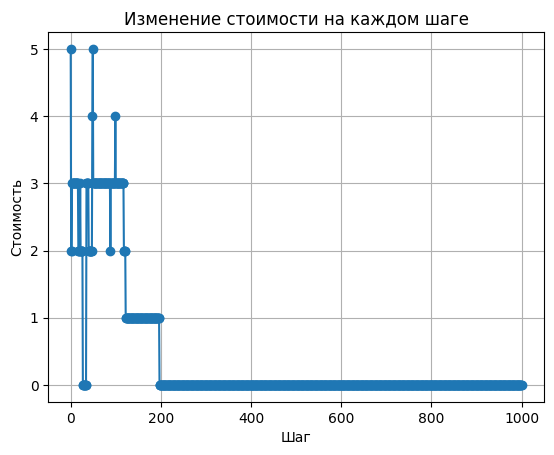

In [9]:
from matplotlib import pyplot as plt

res = SimulatedAnnealing(lambda rng: make_permutation(10, rng), funcs[1], mutate_func, cost_func, random.Random(random_seed)).get_solution(1000)
print(res[1])

plt.plot([i[1] for i in res[2]], marker='o')
plt.xlabel("Шаг")
plt.ylabel("Стоимость")
plt.title("Изменение стоимости на каждом шаге")
plt.grid(True)
plt.show()

### Анализ графика
Как видно из графика, наша стоимость на протяжении работы алгоритма увеличивалась только в начале его работы. Также добиться хорошего результата получилось уже на количестве итераций около 25.

## Решение задачи о расстановке ферзей генетическим алгоритмом

### Функция селекции
Функция селекции будет представлять собой нечто вроде турнирной функции селекции. Перемешаем массив и для каждой пары последовательных элементов выберем тот, у которого целевая функция лучше.

In [10]:
def selection_func(population: list, rng: random.Random, fitness_func) -> list:
    pop = population.copy()
    rng.shuffle(pop)
    winners = []
    for i in range(0, len(pop), 2):
        if(i + 1 >= len(pop)):
            winners.append(pop[i])
            break
        a, b = pop[i], pop[i+1]
        winners.append(a if fitness_func(a) <= fitness_func(b) else b)
    return winners

### Функция кроссовера

In [11]:
def crossover_func(parent1: list[int], parent2: list[int], rng: random.Random) -> list[int]:
    res = []
    used = [0 for i in range(len(parent1))]
    for i in range(len(parent1)):
        if rng.random() < 0.5:
            res.append(parent1[i])
            used[res[-1]] = 1
    for i in parent2:
        if not used[i]:
            res.append(i)
            used[i] = 1
    return res

### Класс генетического алгоритма
Находится в algorithms/ga.py

In [12]:
import os
import sys


sys.path.append(os.path.abspath("../src"))

from sa_ga_comparison.algorithms.ga import GeneticAlgorithm

### Пробуем получить решения
Сгенерируем решения для N = [10, 50, 100, 200]

In [13]:
generations = 10000
population_size = 100

for N in [10, 50, 100, 200]:
    ga = GeneticAlgorithm(population_size=population_size, mutation_rate=0.3, crossover_rate=0.7, fitness_fn=cost_func, mutation_fn=mutate_func, crossover_fn=crossover_func, generation_fn=lambda rng: make_permutation(N, rng), selection_fn=selection_func, rng=random.Random(random_seed))
    res = ga.get_solution(generations)
    print(res[0], res[1])

[9, 5, 2, 0, 7, 3, 8, 6, 4, 1] 0.0
[22, 39, 47, 23, 1, 14, 21, 0, 16, 9, 6, 27, 43, 49, 20, 29, 45, 4, 42, 38, 12, 48, 3, 33, 18, 5, 37, 26, 40, 19, 15, 10, 34, 46, 25, 11, 31, 41, 36, 44, 7, 13, 30, 32, 8, 28, 24, 17, 2, 35] 0.0
[52, 91, 65, 56, 5, 42, 50, 18, 62, 34, 29, 78, 8, 40, 19, 64, 61, 74, 86, 69, 6, 1, 38, 79, 99, 71, 16, 24, 88, 44, 81, 9, 63, 72, 98, 55, 48, 39, 27, 43, 15, 28, 77, 31, 53, 12, 3, 94, 70, 90, 92, 85, 75, 93, 4, 20, 66, 21, 87, 89, 11, 59, 32, 47, 45, 60, 0, 95, 82, 17, 23, 37, 41, 10, 80, 83, 68, 49, 2, 96, 57, 33, 25, 46, 97, 84, 54, 13, 67, 14, 22, 76, 7, 35, 30, 26, 51, 36, 58, 73] 0.0
[81, 194, 3, 96, 38, 174, 152, 89, 61, 140, 144, 52, 160, 123, 105, 35, 127, 8, 22, 15, 181, 24, 111, 164, 31, 54, 57, 149, 100, 84, 153, 95, 187, 148, 70, 178, 98, 131, 154, 163, 4, 49, 40, 101, 161, 146, 109, 103, 185, 7, 115, 56, 199, 71, 175, 47, 91, 107, 26, 156, 198, 80, 150, 162, 196, 138, 191, 99, 117, 135, 48, 41, 23, 87, 43, 180, 118, 10, 44, 69, 21, 46, 158, 14,

### Анализ результатов
Как видно, для N >= 200 генетический алгоритм такой структуры не дает приемлемый ответ. Давайте попробуем изменить функцию мутации и поменять другие гиперпараметры.

In [14]:
generations = 10000
population_size = 50

def mutate_func2(permutation: list[int], rng: random.Random) -> list[int]:
    if rng.random() < 0.3:
        return make_permutation(len(permutation), rng)
    return mutate_func(permutation, rng)

ga = GeneticAlgorithm(population_size=population_size, mutation_rate=0.9, crossover_rate=0.5, fitness_fn=cost_func, mutation_fn=mutate_func2, crossover_fn=crossover_func, generation_fn=lambda rng: make_permutation(300, rng), selection_fn=selection_func, rng=random.Random(random_seed))
res = ga.get_solution(generations)
print(res[0], res[1])

[108, 155, 157, 172, 92, 173, 230, 79, 138, 259, 97, 210, 153, 265, 125, 43, 271, 110, 178, 121, 69, 234, 95, 103, 170, 147, 85, 137, 235, 118, 201, 44, 165, 129, 177, 231, 2, 149, 226, 61, 297, 25, 88, 253, 8, 78, 260, 200, 80, 100, 189, 228, 225, 48, 249, 74, 139, 11, 273, 117, 209, 158, 221, 194, 104, 258, 54, 131, 288, 113, 87, 246, 216, 19, 3, 254, 252, 26, 204, 124, 250, 112, 71, 52, 207, 282, 123, 227, 145, 16, 268, 220, 68, 251, 219, 94, 212, 159, 245, 291, 41, 37, 144, 42, 21, 29, 174, 296, 185, 57, 275, 267, 1, 222, 5, 101, 261, 107, 133, 276, 248, 49, 84, 166, 195, 76, 99, 279, 59, 109, 51, 263, 180, 237, 56, 198, 274, 17, 224, 40, 114, 119, 208, 115, 182, 215, 86, 168, 272, 286, 33, 77, 205, 20, 239, 0, 67, 217, 46, 277, 60, 188, 82, 183, 218, 284, 64, 132, 285, 39, 206, 127, 13, 181, 255, 236, 187, 256, 6, 244, 171, 190, 91, 30, 34, 22, 289, 122, 243, 38, 53, 197, 135, 146, 269, 70, 65, 75, 31, 143, 134, 96, 202, 162, 81, 36, 262, 111, 290, 293, 12, 240, 55, 160, 238, 186,

### Анализ результатов после изменения гиперпараметров
Меняя гиперпараметры, я смог получить верный ответ для N = 300.

### Визуализация изменения текущей стоимости
Для лучшего понимания работы генетического алгоритма провизуализируем изменение значения целевой функции для N = 50 с количеством поколений = 1000 и размером популяции = 50.

0.0


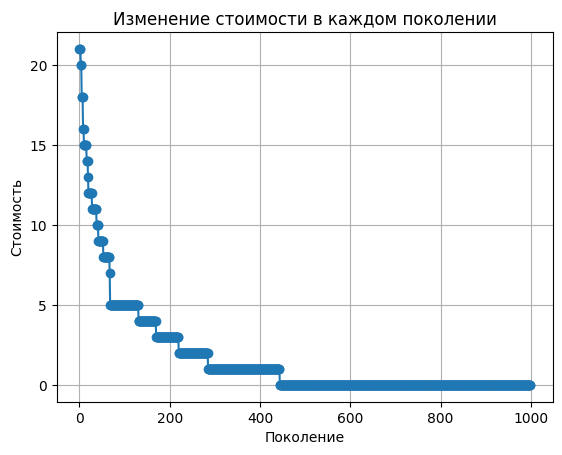

In [15]:
ga = GeneticAlgorithm(population_size=50, mutation_rate=0.9, crossover_rate=0.5, fitness_fn=cost_func, mutation_fn=mutate_func2, crossover_fn=crossover_func, generation_fn=lambda rng: make_permutation(50, rng), selection_fn=selection_func, rng=random.Random(random_seed))
res = ga.get_solution(1000)
print(res[1])

plt.plot([i[1] for i in res[2]], marker='o')
plt.xlabel("Поколение")
plt.ylabel("Стоимость")
plt.title("Изменение стоимости в каждом поколении")
plt.grid(True)
plt.show()

### Анализ графика
Как видно из графика, значение целевой функции только уменьшается, что неудивительно, ведь самая лучшая особь всегда выигрывает селекцию.

## Сраниваем методы для решения задачи о расстановки ферзей
Очевидным победителем тут выходит метод отжига. Давайте перечислим его преимущества:
1. Простота написания (требуется написать меньше вспомогательных функций)
2. Скорость работы (по блокам, в которых выполнялись запуски метода отжига видно, что он работает в разы быстрее)
3. Решение для больших N (связано со скоростью работы, если выставить огромное кол-во поколений и размеры популяций генетика тоже справится)  
Однако, не стоит недооценивать генетический алгоритм, так как за ним остается важное преимущество - интуитивность. Действительно, в отжиге нужно понимать, как работают функции температур и подбирать их аккуратно, в то время как гиперпараметры генетического алгоритма максимально понятны обывателю.

### Конкретное сравнение времени работы алгоритмов
Давайте для N = 100 попробуем подобрать гиперпараметры алгоритмов, которые обеспечат время работы близкое к лучшему для данных реализаций, и сравним время работы алгоритмов с такими гиперпараметрами.

Найдем количество итераций для метода отжига

In [16]:
sa_iterations = 100000

for iterations in [10, 100, 1000, 10000]:
    sa = SimulatedAnnealing(lambda rng: make_permutation(100, rng), temp_func_2, mutate_func, cost_func, random.Random(random_seed))
    solution, cost, history = sa.get_solution(iterations)
    if cost == 0:
        sa_iterations = iterations
        break

print(f"Simulated Annealing iterations: {sa_iterations}")

Simulated Annealing iterations: 10000


Найдем комбинацию кол-вопоколений-размер популяции для генетического алгоритма. При этом сначала булем перебирать размер популяции, т.к. асимптотика моей реализации оценивается как O( I * (P*N + P*LOG(P)*N) )

In [17]:
ga_generations = 100000
ga_population_size = 50

for population_size in [10, 20, 50, 100]:
    was = False
    for generations in [10, 100, 1000, 10000]:
        ga = GeneticAlgorithm(population_size=population_size, mutation_rate=0.9, crossover_rate=0.5, fitness_fn=cost_func, mutation_fn=mutate_func2, crossover_fn=crossover_func, generation_fn=lambda rng: make_permutation(100, rng), selection_fn=selection_func, rng=random.Random(random_seed))
        solution, cost, history = ga.get_solution(generations)
        if cost == 0:
            ga_generations = generations
            ga_population_size = population_size
            was = True
            break
    if was:
        break

print(f"Genetic Algorithm generations: {ga_generations}, population size: {ga_population_size}")

Genetic Algorithm generations: 10000, population size: 10


### Особенности гиперпараметров
Можно заметить, что количество итераций отжига совпало с количеством поколений генетического алгоритма. Что это значит? А то, что в нашем случае ГА будет работать схожим образом с отжигом, заместо неудачных шагов в отжиге мы будем генерировать новую перестановку в другой части функции. Судя по размеру популяции, можно сказать, что локальных минимумов не так уж много или многие из них являются и глобальными минимумами.

### Сравниваем время работы

In [18]:
from sa_ga_comparison.utils.benchmarks import run_experiment


sa = SimulatedAnnealing(lambda rng: make_permutation(100, rng), temp_func_2, mutate_func, cost_func, random.Random(random_seed))
ga = GeneticAlgorithm(population_size=ga_population_size, mutation_rate=0.9, crossover_rate=0.5, fitness_fn=cost_func, mutation_fn=mutate_func2, crossover_fn=crossover_func, generation_fn=lambda rng: make_permutation(100, rng), selection_fn=selection_func, rng=random.Random(random_seed))

res_sa, avg_time_sa = run_experiment(lambda: sa.get_solution(sa_iterations))
res_ga, avg_time_ga = run_experiment(lambda: ga.get_solution(ga_generations))

print(avg_time_sa)
print(avg_time_ga)


0.4290290061999258
15.263979757000016


## Итог
Для решения этой задачи я бы выбрал именно метод отжига, так как он проще в написании, требует меньшего количества гиперпараметров для настройки и работает в разы быстрее генетического алгоритма в рамках текущей задачи.